In [9]:
from typing import Optional, Dict, Any
import numpy as np
import pandas as pd
from research.backtest import *

TRADING_DAYS = 252

def top_n_backtest_boolean(
    price_df: pd.DataFrame,
    eligible: pd.DataFrame,                 # boolean: True means passes rules at t
    rank_score: Optional[pd.DataFrame] = None,  # float score to rank eligible names (optional)
    top_n: int = 10,
    H: int = 5,
    entry_mode: str = "next_close",         # "next_close" or "next_open"
    costs_bps: float = 0.0,                 # cost per unit turnover (bps)
    min_assets: int = 50,                   # require at least this many eligible+tradable to trade
) -> Dict[str, Any]:
    """
    Non-overlapping H-day Top-N backtest using boolean eligibility filter.

    Convention:
      - At formation date t, compute eligibility using info up to close[t]
      - Enter at t+1 (close or open depending on entry_mode)
      - Exit at t+H+1 (same price field)
      - One return observation per formation date (non-overlapping holds)
      - Rebalance every H days

    Returns:
      port_ret_gross, port_ret_net: Series indexed by formation dates (rebalance dates)
      weights_rebal: weights on formation dates
      turnover: turnover on formation dates
      coverage: fraction of universe that is eligible+tradable on formation dates
      n_hold: number of names held on formation dates
      meta: parameters
    """
    if entry_mode not in {"next_close", "next_open"}:
        raise ValueError("entry_mode must be 'next_close' or 'next_open'")
    if top_n <= 0:
        raise ValueError("top_n must be positive")
    if H <= 0:
        raise ValueError("H must be positive")

    # Prices
    if entry_mode == "next_close":
        px = price_df["Close"].sort_index()
    else:
        px = price_df["Open"].sort_index()

    dates = px.index
    tickers = px.columns

    # Align inputs
    eligible = eligible.reindex(index=dates, columns=tickers)
    if rank_score is not None:
        rank_score = rank_score.reindex(index=dates, columns=tickers)

    # Entry/exit prices for H-day hold from formation date t
    entry_px = px.shift(-1)          # at t+1
    exit_px = px.shift(-(H + 1))     # at t+H+1
    ret_fwd_H = exit_px / entry_px - 1.0

    # Rebalance dates (formation dates)
    rebal_dates = dates[::H]

    out_dates = []
    weights_list = []
    port_ret_gross = []
    coverage_list = []
    n_hold_list = []

    prev_w = None
    turnover_list = []
    cost_list = []

    universe_size = len(tickers)

    for t in rebal_dates:
        if t not in dates:
            continue

        # tradability: need entry and exit prices
        tradable = entry_px.loc[t].notna() & exit_px.loc[t].notna() & ret_fwd_H.loc[t].notna()
        elig_t = eligible.loc[t].fillna(False)

        valid = elig_t & tradable
        n_valid = int(valid.sum())
        coverage_list.append(n_valid / universe_size if universe_size else np.nan)

        if n_valid < max(min_assets, top_n):
            # skip trading on this date
            continue

        candidates = valid[valid].index

        # Choose top N among candidates
        if rank_score is None:
            # No ranking: pick any top_n deterministically (e.g., by ticker)
            chosen = list(candidates[:top_n])
        else:
            s = rank_score.loc[t, candidates].copy()
            s = s.replace([np.inf, -np.inf], np.nan).dropna()
            if len(s) < top_n:
                continue
            chosen = list(s.sort_values(ascending=False).head(top_n).index)

        # weights
        w = pd.Series(0.0, index=tickers)
        w.loc[chosen] = 1.0 / top_n

        # portfolio return (H-day) for this formation date
        r = ret_fwd_H.loc[t, chosen].mean()

        # turnover and costs at rebalance points
        if prev_w is None:
            turnover = np.nan
            cost = 0.0
        else:
            dw = (w - prev_w).abs().sum()
            turnover = 0.5 * float(dw)
            cost = (costs_bps / 10000.0) * turnover

        prev_w = w

        out_dates.append(t)
        weights_list.append(w)
        port_ret_gross.append(float(r))
        turnover_list.append(turnover)
        cost_list.append(cost)
        n_hold_list.append(int((w > 0).sum()))

    if len(out_dates) == 0:
        raise ValueError("No rebalance dates produced a valid portfolio. Check min_assets/top_n/eligibility coverage.")

    w_rebal = pd.DataFrame(weights_list, index=out_dates)
    port_ret_gross = pd.Series(port_ret_gross, index=out_dates, name="port_ret_gross")
    turnover_s = pd.Series(turnover_list, index=out_dates, name="turnover")
    cost_s = pd.Series(cost_list, index=out_dates, name="cost")
    port_ret_net = (port_ret_gross - cost_s).rename("port_ret_net")
    coverage_s = pd.Series(coverage_list, index=rebal_dates[:len(coverage_list)], name="coverage").reindex(out_dates)
    n_hold_s = pd.Series(n_hold_list, index=out_dates, name="n_hold")

    return {
        "port_ret_gross": port_ret_gross,
        "port_ret_net": port_ret_net,
        "weights_rebal": w_rebal,
        "turnover": turnover_s,
        "cost": cost_s,
        "coverage": coverage_s,
        "n_hold": n_hold_s,
        "meta": {
            "top_n": top_n,
            "H": H,
            "entry_mode": entry_mode,
            "costs_bps": costs_bps,
            "min_assets": min_assets,
            "non_overlapping": True,
        }
    }


def perf_summary(r: pd.Series, freq: float) -> dict:
    return {
        "ann_return_geo": annualised_return_geo(r, freq=freq),
        "ann_vol": annualised_vol(r, freq=freq),
        "sharpe": sharpe_ratio(r, freq=freq),
        "max_dd": max_drawdown(r),
        "n_obs": int(r.dropna().shape[0]),
    }

In [10]:
import yfinance as yf

START_DATE = "2015-01-01"
END_DATE   = "2025-12-12"

hsi_stocks = pd.read_excel("/Users/henrywzh/Desktop/hk_stock_ejfq.xlsx")

def code_int_to_hk(code: int) -> str:
    return f"{int(code):04d}.HK"

UNIVERSE = hsi_stocks["代码"].apply(code_int_to_hk).tolist()

price_df = yf.download(UNIVERSE, START_DATE, END_DATE, auto_adjust=False, group_by="column")
hsi = yf.download("^HSI", START_DATE, END_DATE, auto_adjust=False)

# Extract close matrices
close = price_df["Close"].sort_index()
hsi_close = hsi["Close"].sort_index()

# Common calendar (optional but recommended)
common_dates = close.index.intersection(hsi_close.index)
close = close.loc[common_dates]
hsi_close = hsi_close.loc[common_dates]

[*********************100%***********************]  108 of 108 completed
[*********************100%***********************]  1 of 1 completed


In [20]:
def build_boolean_eligible_from_text(
    price_df: pd.DataFrame,
    tight_pct: float = 0.02,       # 2% MA dispersion threshold
    vr_threshold: float = 1.5,     # "volume ratio doubled" proxy: >1.5x baseline
    vol_window: int = 20,
    cont_window: int = 2,          # sustained for K days
) -> pd.DataFrame:
    close = price_df["Close"].sort_index()
    vol = price_df["Volume"].sort_index()

    # MAs
    ma5  = close.rolling(5,  min_periods=5).mean()
    ma10 = close.rolling(10, min_periods=10).mean()
    ma20 = close.rolling(20, min_periods=20).mean()
    # ma30 = close.rolling(30, min_periods=30).mean()

    # 1) 多头排列初开 (ordering)
    initial_open = (ma5 > ma10) & (ma10 > ma20)

    # 2) 粘合 (tight)
    mx = pd.concat([ma5, ma10, ma20], axis=1).groupby(level=0, axis=1).max()
    mn = pd.concat([ma5, ma10, ma20], axis=1).groupby(level=0, axis=1).min()
    dispersion = (mx - mn) / close
    tight = dispersion <= tight_pct

    # # 3) 量比倍增 (VR) + 连续性
    vma = vol.rolling(vol_window, min_periods=vol_window).mean()
    vr = vol / vma
    vol_boost = (vr >= vr_threshold)
    vol_boost_cont = vol_boost.rolling(cont_window, min_periods=cont_window).min().astype(bool)

    eligible = initial_open & tight & vol_boost_cont
    return eligible


def build_rank_score_vr(price_df: pd.DataFrame, vol_window: int = 20) -> pd.DataFrame:
    vol = price_df["Volume"].sort_index()
    vma = vol.rolling(vol_window, min_periods=vol_window).mean()
    vr = vol / vma
    return vr

In [21]:
# 1) eligibility boolean signal
eligible = build_boolean_eligible_from_text(
    price_df,
    tight_pct=0.02,
    vr_threshold=1.5,
    vol_window=20,
    cont_window=2,
)

# 2) optional ranking score (pick strongest VR among eligible)
rank_score = build_rank_score_vr(price_df, vol_window=20)

# 3) run backtest
res = top_n_backtest_boolean(
    price_df=price_df,
    eligible=eligible,
    rank_score=rank_score,   # set None if you want "all eligible" or deterministic selection
    top_n=10,
    H=5,
    entry_mode="next_close",
    costs_bps=10,
    min_assets=5,
)

# 4) performance summary (IMPORTANT: freq = 252/H for non-overlapping H-day returns)
freq = TRADING_DAYS / 5
print("NET:", perf_summary(res["port_ret_net"], freq=freq))
print("GROSS:", perf_summary(res["port_ret_gross"], freq=freq))


/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_87890/4015970602.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mx = pd.concat([ma5, ma10, ma20], axis=1).groupby(level=0, axis=1).max()
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_87890/4015970602.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  mn = pd.concat([ma5, ma10, ma20], axis=1).groupby(level=0, axis=1).min()


ValueError: No rebalance dates produced a valid portfolio. Check min_assets/top_n/eligibility coverage.

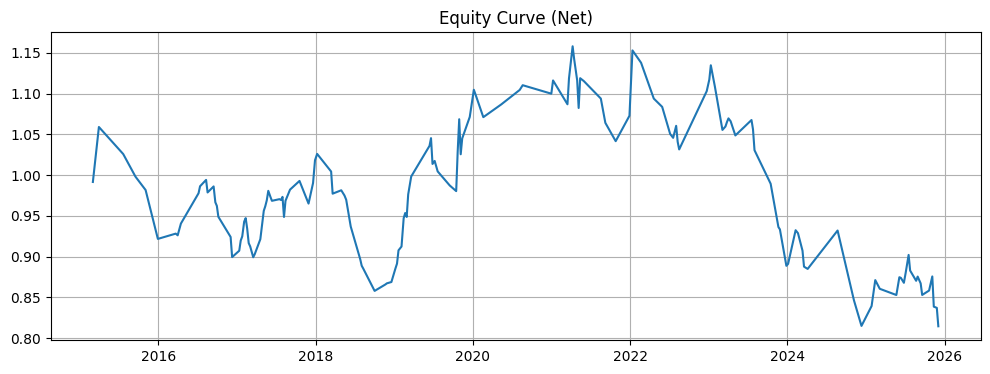

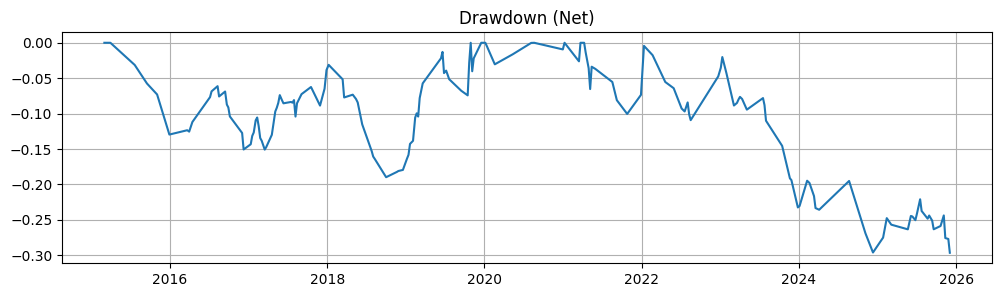

In [19]:
r = res["port_ret_net"].dropna()
eq = (1.0 + r).cumprod()

plt.figure(figsize=(12,4))
plt.plot(eq.index, eq.values)
plt.title("Equity Curve (Net)")
plt.grid(True)
plt.show()

dd = eq / eq.cummax() - 1.0
plt.figure(figsize=(12,3))
plt.plot(dd.index, dd.values)
plt.title("Drawdown (Net)")
plt.grid(True)
plt.show()
